In [1]:
import pymysql
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import transformations
import config
%matplotlib inline

In [2]:
conn = pymysql.connect(config.host, user=config.username,port=config.port,
                           passwd=config.password)

#gather all historical data to build model
RideWaits = pd.read_sql_query("call DisneyDB.RideWaitQuery('2,7,8,9')", conn)

#transform data for model bulding
RideWaits = transformations.transformData(RideWaits)

C:\Users\chrisA\Documents\DisneyWaitTimes\DisneyWaits\src\transformations.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  RideWaits["Month"] = RideWaits["Date"].dt.month
C:\Users\chrisA\Documents\DisneyWaitTimes\DisneyWaits\src\transformations.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  RideWaits["TimeSinceRideOpen"] = (RideWaits["Date"] - RideWaits["OpeningDate"]).dt.days
C:\Users\chrisA\Documents\DisneyWaitTimes\DisneyWaits\src\transformations.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [ ]:
RideWaits[(RideWaits['inEMH'] == 1) & (RideWaits["MagicHourType"] == "Night")] 

In [ ]:
RideWaits.columns

In [ ]:
important_columns = ['RideId', 'Wait','Name','Tier','Location','IntellectualProp','ParkId','DayOfWeek','Weekend','CharacterExperience','inEMH','EMHDay','TimeSinceOpen','TimeSinceMidday','MagicHourType','MinutesSinceOpen','Month']

In [ ]:
ride_waits = RideWaits[important_columns]

In [ ]:
ride_waits = ride_waits.dropna(how = "any")

In [ ]:
ride_waits.shape

In [ ]:
ride_waits['Tier'].value_counts()

In [ ]:
ride_waits['Location'].value_counts()

In [ ]:
ride_waits = ride_waits[ride_waits['Location'] != ""]

In [ ]:
ride_waits['IntellectualProp'].value_counts()

In [ ]:
ride_waits['ParkId'].hist()

In [ ]:
sns.distplot(ride_waits['DayOfWeek'])

In [ ]:
sns.distplot(ride_waits['Wait'])

In [3]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop([column_name], axis = 1)
    return df

In [4]:
import seaborn as sns


def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

In [ ]:
ride_waits.columns

In [ ]:
dummy_columns = ['RideId','Tier','Location','IntellectualProp','ParkId','DayOfWeek','Weekend','CharacterExperience','inEMH','EMHDay','MagicHourType','Month']


In [ ]:
dummy_columns

In [ ]:
for column in dummy_columns:
    ride_waits = create_dummies(ride_waits, column)
    

In [ ]:
for col in ride_waits.columns:
    print(col)

In [ ]:
ride_waits = ride_waits.drop(['Name'], axis = 1)

In [ ]:
correlation = ride_waits.corr()['Wait']
correlation

In [ ]:
correlation = ride_waits.corr()['Wait']
key_correlations = correlation[abs(correlation) > .075]

In [ ]:
key_correlations

In [ ]:
important_cols = list(key_correlations.index)

In [ ]:
important_cols = [x for x in important_cols if x != "Wait"]

In [ ]:
ride_waits_key = ride_waits[important_cols + ["Wait","MinutesSinceOpen"]]

In [ ]:
plot_correlation_heatmap(ride_waits_key)

In [ ]:
#things that are highly correlated to each other are the weekend thing, because if it's not a weekend it is a weekday
#we don't need include all levels of each set

In [ ]:
important_cols = [x for x in important_cols if x != "Weekend_0"]

In [ ]:
important_cols

In [ ]:
important_cols = important_cols + ["MinutesSinceOpen"]

In [ ]:
important_cols

In [ ]:
data = ride_waits_key

In [ ]:
important_cols

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression(normalize = True)
scores = cross_val_score(lr, data[important_cols], data['Wait'], scoring = "neg_median_absolute_error", cv = 10)
mean_error_lr = scores.mean()
print(mean_error_lr)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
scores = cross_val_score(rf, data[important_cols],data['Wait'], scoring = "neg_median_absolute_error", cv = 10)
mean_error_rf = scores.mean()
print(mean_error_rf)

In [ ]:
#maybe since it's time dependent we should add information about the previous step wait time

In [5]:
def get_shift(day, steps):
    previous_steps = {}
    for i in range(1,1+steps):
        current_steps = []
        test_day_current = day.reset_index()
        for index,row in test_day_current.iterrows():
            if index in list(range(i)):
                current_steps.append(0)
            else:
                current_steps.append(test_day_current.loc[index - i,'Wait'])
        
        name = "previous_step"+str(i)
        previous_steps[name] = current_steps
    
    for key,value in previous_steps.items():
        day[key] = value
        
    return day
    

In [6]:
def shift_data(ride_data, shift_range):
    new_data_frame = pd.DataFrame()
    distinct_rides = list(ride_data['RideId'].unique())
    for ride in distinct_rides:
        this_ride = ride_data[ride_data['RideId'] == ride]
        day_list = list(this_ride['Date'].unique())
        for day in day_list:
            day_data = this_ride[this_ride['Date'] == day]
            new_data = get_shift(day_data, shift_range)
            new_data_frame = pd.concat([new_data_frame, new_data])

    return new_data_frame

In [ ]:
new_ride_data = shift_data(RideWaits, 2)

In [ ]:
new_ride_data

In [66]:
def model_transformation(data):
    ride_waits = data
    
    important_columns = ['RideId','Date', 'Wait','Name','Tier','Location','IntellectualProp','ParkId','DayOfWeek','Weekend','CharacterExperience','inEMH','EMHDay','TimeSinceOpen','TimeSinceMidday','MagicHourType','MinutesSinceOpen','Month']
    ride_waits = ride_waits[important_columns]
    ride_waits = ride_waits[ride_waits['Location'] != ""]
    
    ride_waits = ride_waits.dropna(how = "any")
    
    ride_waits = shift_data(ride_waits,5)
    
    dummy_columns = ['RideId','Tier','Location','IntellectualProp','ParkId','DayOfWeek','Weekend','CharacterExperience','inEMH','EMHDay','MagicHourType','Month']
    ride_waits = ride_waits.drop(['Name'], axis = 1)
    for column in dummy_columns:
        ride_waits = create_dummies(ride_waits, column)
        
    correlation = ride_waits.corr()['Wait']
    key_correlations = correlation[abs(correlation) > .075]
    important_cols = list(key_correlations.index)
    important_cols = important_cols + ["Wait","MinutesSinceOpen", "previous_step1","previous_step2","previous_step3","previous_step4","previous_step5"]
    important_cols = [x for x in important_cols if x != "Weekend_0"]
    important_cols = list(set(important_cols))
    ride_waits_key = ride_waits[important_cols]
    
    
    return ride_waits_key

In [67]:
data = model_transformation(RideWaits)

C:\Users\chrisA\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [50]:
data.columns

Index(['RideId_107785', 'IntellectualProp_StarWars',
       'Location_DinoLand U.S.A.', 'MinutesSinceOpen',
       'Location_Discovery Island', 'RideId_18375495', 'RideId_80010182',
       'ParkId_9', 'Location_Pandora   The World of Avatar', 'RideId_80010199',
       'IntellectualProp_Muppets', 'RideId_80010152', 'RideId_80010228',
       'RideId_62992', 'Location_Toy Story Land', 'ParkId_2',
       'Location_Sunset Boulevard', 'RideId_18904138', 'IntellectualProp_Fab5',
       'Tier_minor_attraction', 'RideId_80010151', 'RideId_80010150',
       'RideId_209857', 'RideId_80010170', 'IntellectualProp_Avatar',
       'Weekend_1', 'TimeSinceMidday', 'RideId_18665185',
       'Location_Animation Courtyard', 'RideId_16767263', 'Month_9',
       'RideId_18368385', 'Location_Future World', 'Tier_super_headliner',
       'RideId_80010117', 'RideId_80010162', 'Wait', 'RideId_80010176',
       'Location_Echo Lake', 'RideId_16767284', 'Month_10', 'Tier_diversion',
       'Tier_headliner', 'RideI

In [68]:
important_columns = data.columns

In [69]:
important_columns = [x for x in important_columns if x != "Wait"]

In [70]:
important_cols = important_columns

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression(normalize = True)
scores = cross_val_score(lr, data[important_cols], data['Wait'], scoring = "neg_median_absolute_error", cv = 10)
mean_error_lr = scores.mean()
print(mean_error_lr)

-29094444380302.45


In [55]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
scores = cross_val_score(rf, data[important_cols],data['Wait'], scoring = "neg_median_absolute_error", cv = 10)
mean_error_rf = scores.mean()
print(mean_error_rf)

-7.123591879906838


In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

hyperparameters = {"criterion": ["mse"],
                   "max_depth": [5, 10,15],
                   "max_features": ["auto","log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [2,5],
                   "n_estimators": [10,50,100]
}

clf = RandomForestRegressor(random_state=1)
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=3)

grid.fit(data[important_cols], data['Wait'])



GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['mse'], 'max_depth': [5, 10, 15], 'max_features': ['auto', 'log2', 'sqrt'], 'min_samples_leaf': [1, 5], 'min_samples_split': [2, 5], 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [57]:
best_params = grid.best_params_
best_score = grid.best_score_

In [58]:
best_params

{'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [59]:
best_score

0.5244070332008035

In [72]:
clf = RandomForestRegressor(**best_params)
scores = cross_val_score(clf, data[important_cols], data['Wait'],scoring = "neg_median_absolute_error", cv= 10)
mean_error_rf = scores.mean()
print(mean_error_rf)

-4.980121758036972


In [73]:
model = clf.fit(data[important_cols], data['Wait'])

In [ ]:
model

In [ ]:
data[data[]]

In [ ]:
data.columns

In [75]:
test_track =data[data['RideId_80010199'] == 1]

In [76]:
test_track['TimeSinceMidday']

8        5
22       4
33       4
44       4
58       4
69       4
153      1
165      1
177      1
189      1
201      1
223      1
235      0
247      0
259      0
271      1
283      1
295      1
307      1
319      2
331      2
343      2
355      2
367      3
390      3
501      6
511      6
520      6
2288     5
2302     4
        ..
91252    1
91264    1
91276    1
91287    2
91299    2
91311    2
91323    2
91335    3
91346    3
91358    3
91370    3
91382    4
91394    4
91406    4
91418    4
91430    5
91442    5
91454    5
91466    5
91478    6
91490    6
91501    6
91512    6
91535    7
91546    7
91556    7
91566    8
91576    8
91586    8
91596    8
Name: TimeSinceMidday, Length: 1276, dtype: int64

In [77]:
test_track = test_track.head(28)

In [78]:
test_track

,RideId_107785,IntellectualProp_StarWars,Location_DinoLand U.S.A.,MinutesSinceOpen,Location_Discovery Island,RideId_18375495,RideId_80010182,ParkId_9,Location_Pandora The World of Avatar,RideId_80010199,...,Location_Echo Lake,RideId_16767284,Month_10,Tier_diversion,Tier_headliner,previous_step3,Location_Grand Avenue,RideId_18665186,RideId_207395,previous_step5
8,0,0,0,36.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,109.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
33,0,0,0,111.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44,0,0,0,112.0,0,0,0,0,0,1,...,0,0,0,0,0,35,0,0,0,0
58,0,0,0,115.0,0,0,0,0,0,1,...,0,0,0,0,0,50,0,0,0,0
69,0,0,0,118.0,0,0,0,0,0,1,...,0,0,0,0,0,50,0,0,0,35
153,0,0,0,244.0,0,0,0,0,0,1,...,0,0,0,0,0,50,0,0,0,50
165,0,0,0,245.0,0,0,0,0,0,1,...,0,0,0,0,0,60,0,0,0,50
177,0,0,0,246.0,0,0,0,0,0,1,...,0,0,0,0,0,60,0,0,0,50
189,0,0,0,253.0,0,0,0,0,0,1,...,0,0,0,0,0,25,0,0,0,60


In [79]:
test_track['predictions'] = model.predict(test_track[important_cols])

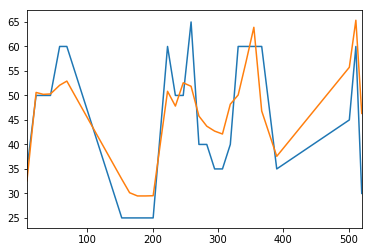

In [65]:
test_track.Wait.plot()
test_track.predictions.plot()

In [ ]:
test_track[['previous_step1', 'previous_step2','Wait','predictions']]

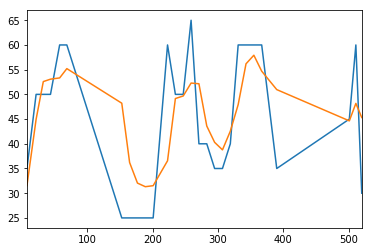

In [80]:
test_track.Wait.plot()
test_track.predictions.plot()

In [81]:
inspect(model)

NameError: name 'inspect' is not defined

In [82]:
model.__dict__

{'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
 'base_estimator_': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
 'bootstrap': True,
 'class_weight': None,
 'criterion': 'mse',
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'min_impurity_split',
  'random_state'),
 'estimators_': [DecisionTre

In [85]:
model.feature_importances_

array([1.07299713e-04, 3.52458666e-04, 6.77302963e-04, 1.14058549e-02,
       4.86298035e-04, 1.16188432e-03, 2.89215670e-03, 3.01644979e-03,
       3.26046247e-02, 5.04830090e-03, 3.83753031e-04, 1.56233120e-04,
       1.43977458e-03, 5.39229069e-04, 7.21993663e-03, 9.26487681e-04,
       3.30444008e-03, 3.72618330e-04, 8.65472569e-03, 1.31771284e-03,
       1.61263049e-01, 6.75570597e-03, 6.39818079e-04, 2.36995600e-04,
       6.79095399e-04, 1.41656388e-04, 3.55835350e-02, 1.62984959e-03,
       5.66808318e-03, 2.95532675e-01, 4.49990366e-03, 3.06490207e-04,
       1.08269514e-01, 1.06988011e-04, 5.38887714e-03, 3.16512654e-04,
       1.19737053e-03, 8.27547564e-03, 1.16685935e-03, 2.25472493e-04,
       3.65615843e-03, 3.83759217e-04, 9.54211483e-03, 5.17241779e-03,
       8.07495598e-04, 1.92547894e-03, 1.71675008e-01, 2.71989210e-04,
       1.82446025e-02, 2.09657066e-04, 6.81598488e-02])

AttributeError: 'RandomForestRegressor' object has no attribute 'classes_'